In [1]:
import numpy as np
import pandas as pd
import pydicom
from pathlib import Path
import clip
import matplotlib.pyplot as plt; plt.rcParams['image.cmap'] = 'bone'
from medmnist import BreastMNIST, BloodMNIST, ChestMNIST, PneumoniaMNIST, TissueMNIST
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import transforms
import torch
import re

In [2]:
data_path = Path('../data/CANDID-PTX/')
dicom_path = list((data_path/'dataset').iterdir())

In [3]:
df = pd.read_csv(data_path/'Pneumothorax_reports.csv')

In [4]:
n = 100

tensor = lambda x: torch.tensor(x, device='cuda', dtype=torch.float)
upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)
channels_first = lambda x: np.moveaxis(x, -1, 1)

root='../data/medmnist'
# mnist = tensor(MNIST('../data/', train=True, download=False, transform=transforms.Normalize((0.1307,), (0.3081,))).data[:n])

cifar = CIFAR10('../data/', train=True, download=False).data[:n]
chest = ChestMNIST('train', root=root, download=False).imgs[:n][:, :, :, None].repeat(3, 3) 
pneumonia = PneumoniaMNIST('train', root=root, download=False).imgs[:n] 
blood = BloodMNIST('train', root=root, download=False).imgs[:n] 
tissue = TissueMNIST('train', root=root, download=False).imgs[:n][:, :, :, None].repeat(3, 3) 

In [5]:
model, preprocess = clip.load("ViT-B/32", device='cuda', jit=False)
_transforms = transforms.Compose([
    transforms.ToPILImage(),
    preprocess,
])
# preprocess = transforms.Compose([
#     preprocess.transforms[0],
#     preprocess.transforms[1],
#     preprocess.transforms[3],
#     preprocess.transforms[4],
# ])

In [6]:
cifar_images = torch.stack([_transforms(img) for img in cifar])
cifar_image_features = model.encode_image(cifar_images.cuda())
chest_images = torch.stack([_transforms(img) for img in chest])
chest_image_features = model.encode_image(chest_images.cuda())
blood_images = torch.stack([_transforms(img) for img in blood])
blood_image_features = model.encode_image(blood_images.cuda())
tissue_images = torch.stack([_transforms(img) for img in tissue])
tissue_image_features = model.encode_image(tissue_images.cuda())
pneumonia_images = torch.stack([_transforms(img) for img in pneumonia])
pneumonia_image_features = model.encode_image(pneumonia_images.cuda())

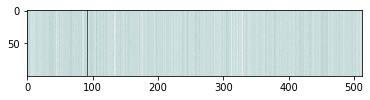

In [7]:
plt.imshow(tissue_image_features.detach().cpu())

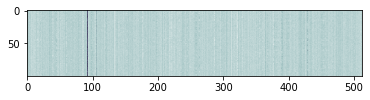

In [8]:
plt.imshow(cifar_image_features.detach().cpu())

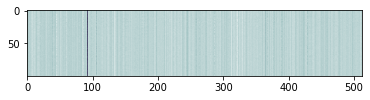

In [9]:
plt.imshow(blood_image_features.detach().cpu())

In [10]:
normal = df.query('EncodedPixels == "-1"')
abnormal = df.query('EncodedPixels != "-1"')

In [55]:
n = 100

normal_images = [
    pydicom.dcmread(
        data_path/'dataset'/normal.iloc[i].SOPInstanceUID
    ).pixel_array
    for i in range(n)
]

abnormal_images = [
    pydicom.dcmread(
        data_path/'dataset'/abnormal.iloc[i].SOPInstanceUID
    ).pixel_array
    for i in range(n)
]


normal_images = torch.stack([
    _transforms(img.astype(np.uint8)[:, :, None].repeat(3, 2))
    for img in normal_images
])
                             
abnormal_images = torch.stack([
    _transforms(img.astype(np.uint8)[:, :, None].repeat(3, 2))
    for img in abnormal_images
])

normal_image_features = model.encode_image(normal_images.cuda())
abnormal_image_features = model.encode_image(abnormal_images.cuda())

In [56]:

window = lambda s, context_length=77: s[:context_length]

longest_sentence = lambda p: max(p.split('\n'), key=len)

normal_reports = normal[:n].Report.map(longest_sentence).map(window).values
abnormal_reports = abnormal[:n].Report.map(longest_sentence).map(window).values

normal_text_features = model.encode_text(clip.tokenize(normal_reports).cuda())
abnormal_text_features = model.encode_text(clip.tokenize(abnormal_reports).cuda())

In [58]:
imdb = pd.read_csv('../data/IMDB Dataset.csv')
imdb = imdb.review[:n].map(window).values

strip_url = lambda s: re.sub(r'http\S+', '', s)

tweet1 = pd.read_csv('../data/Health-Tweets/nprhealth.txt', sep='|', header=None)
tweet2 = pd.read_csv('../data/Health-Tweets/latimeshealth.txt', sep='|', header=None)
tweet3 = pd.read_csv('../data/Health-Tweets/everydayhealth.txt', sep='|', header=None)

tweet1 = tweet1.iloc[:n, 2].map(strip_url).map(window).values
tweet2 = tweet2.iloc[:n, 2].map(strip_url).map(window).values
tweet3 = tweet3.iloc[:n, 2].map(strip_url).map(window).values

imdb_text_features = model.encode_text(clip.tokenize(imdb).cuda())
tweet1_text_features = model.encode_text(clip.tokenize(tweet1).cuda())
tweet2_text_features = model.encode_text(clip.tokenize(tweet2).cuda())
tweet3_text_features = model.encode_text(clip.tokenize(tweet3).cuda())

In [60]:
cov = lambda mat: (1 / mat.shape[0]) * mat.T @ mat

def svd(covariance_matrix):
    eig_val, eig_vec = np.linalg.eig(covariance_matrix)
    eig_val = eig_val.real
    return eig_val, eig_vec

def div_rel_func(buyer_eig_val, buyer_eig_vec, seller_covariance, threshold=1e-0):
    seller_eig_val = np.zeros([len(seller_covariance)])
    Diversity = 1
    Relevance = 1
    count_root = 0
    
    for i in range(len(seller_covariance)):
        if buyer_eig_val[i] >= threshold:
            count_root += 1
            vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])
            seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))
            Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
            Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 

    return (Diversity)**(1/count_root), (Relevance)**(1/count_root), count_root
    

In [72]:
buyer = normal_image_features.detach().cpu().numpy().astype(np.float64)
seller_1 = abnormal_image_features.detach().cpu().numpy().astype(np.float64)
seller_2 = chest_image_features.detach().cpu().numpy().astype(np.float64)
seller_3 = pneumonia_image_features.detach().cpu().numpy().astype(np.float64)
seller_4 = blood_image_features.detach().cpu().numpy().astype(np.float64)
seller_5 = tissue_image_features.detach().cpu().numpy().astype(np.float64)
seller_6 = normal_text_features.detach().cpu().numpy().astype(np.float64)
seller_7 = abnormal_text_features.detach().cpu().numpy().astype(np.float64)
seller_8 = imdb_text_features.detach().cpu().numpy().astype(np.float64)
seller_9 = tweet1_text_features.detach().cpu().numpy().astype(np.float64)

buyer_cov = cov(buyer)
buyer_eig_val, buyer_eig_vec = svd(buyer_cov)
seller_1_cov = cov(seller_1)
seller_2_cov = cov(seller_2)
seller_3_cov = cov(seller_3)
seller_4_cov = cov(seller_4)
seller_5_cov = cov(seller_5)
seller_6_cov = cov(seller_6)
seller_7_cov = cov(seller_7)
seller_8_cov = cov(seller_8)
seller_9_cov = cov(seller_9)

buyer_rel, buyer_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov)
seller_1_rel, seller_1_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_1_cov)
seller_2_rel, seller_2_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_2_cov)
seller_3_rel, seller_3_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_3_cov)
seller_4_rel, seller_4_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_4_cov)
seller_5_rel, seller_5_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_5_cov)
seller_6_rel, seller_6_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_6_cov)
seller_7_rel, seller_7_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_7_cov)
seller_8_rel, seller_8_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_8_cov)
seller_9_rel, seller_9_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_9_cov)

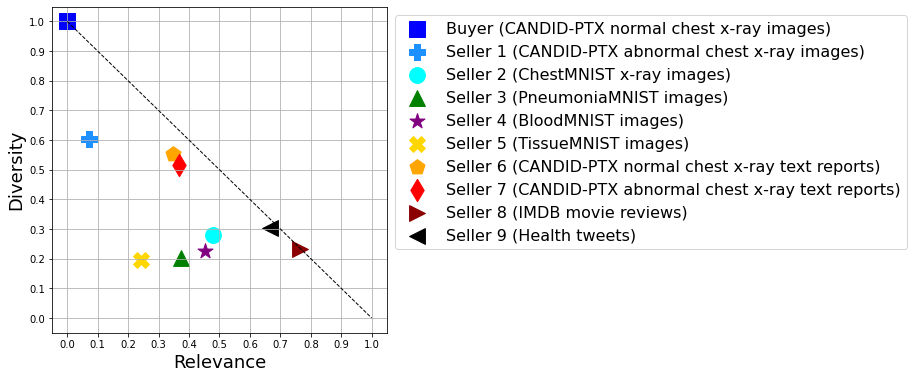

In [87]:
s = 250
plt.figure(figsize=(6, 6))
plt.scatter(buyer_rel, buyer_div, marker='s',  s=s, color='blue',  label='Buyer (CANDID-PTX normal chest x-ray images)')
plt.scatter(seller_1_rel, seller_1_div, marker='P',  s=s, color='dodgerblue',  label='Seller 1 (CANDID-PTX abnormal chest x-ray images)')
plt.scatter(seller_2_rel, seller_2_div, marker='o',  s=s, color='cyan',  label='Seller 2 (ChestMNIST x-ray images)')
plt.scatter(seller_3_rel, seller_3_div, marker='^',  s=s, color='green',  label='Seller 3 (PneumoniaMNIST images)')
plt.scatter(seller_4_rel, seller_4_div, marker='*',  s=s, color='purple',  label='Seller 4 (BloodMNIST images)')
plt.scatter(seller_5_rel, seller_5_div, marker='X',  s=s, color='gold',  label='Seller 5 (TissueMNIST images)')
plt.scatter(seller_6_rel, seller_6_div, marker='p',  s=s, color='orange',  label='Seller 6 (CANDID-PTX normal chest x-ray text reports)')
plt.scatter(seller_7_rel, seller_7_div, marker='d',  s=s, color='red',  label='Seller 7 (CANDID-PTX abnormal chest x-ray text reports)')
plt.scatter(seller_8_rel, seller_8_div, marker='>',  s=s, color='darkred',  label='Seller 8 (IMDB movie reviews)')
plt.scatter(seller_9_rel, seller_9_div, marker='<',  s=s, color='black',  label='Seller 9 (Health tweets)')


plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Diversity', fontsize=18)
plt.legend(prop={'size': 16}, bbox_to_anchor=(1.00, 1.00), fontsize=16)
plt.grid(True)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.savefig('multi-modal-image.png', bbox_inches='tight', )
plt.show()